## 概要

[![qiita2notebook](http://qiita2notebook.herokuapp.com/images/badge.svg)](http://qiita2notebook.herokuapp.com/convert?url=http%3A%2F%2Fqiita.com%2Foimou%2Fitems%2F4a4258a7f7cc2bd70afe)

この記事は、TensorFlowのチュートリアル["MNIST For ML Beginners"](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/beginners/index.html#mnist-for-ml-beginners)を[Jupyter Notebook](https://jupyter.org/)で動かしてみるための記事です。

また、記事上部のバッジからJupyter Notebook版をダウンロードできます。ぜひNotebook形式でコードをいじりながら試してみてください。

* [qiita2notebook - Qiitaの記事をJupyter Notebook化してちょっといじって実行する - Qiita](http://qiita.com/oimou/items/efcbcc32b2d9cf9297e4)

## 記事内で使う記号

* :bulb: で始まる文章はコードをいじる際のヒントです。Jupyter Notebook上で試してみてください。
* :bangbang: で始まる文章はコードをいじる際に気をつけるポイントです。

## 準備

* Python 2.7 (3系では動作未確認)
* Jupyter Notebook
* TensorFlow 0.9 （MNISTデータセットの読み込みのため）
* Matplotlib
* Numpy

## 1. 必要なライブラリを読み込もう

必要なライブラリをimportしておきます。




In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

/Users/yahata/.pyenv/versions/2.7.10/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')



## 2. MNIST画像を読み込もう

MNISTは、機械学習などによく使われる手書き文字の画像データセットです。最初はダウンロードに少し時間がかかります。




In [2]:
from tensorflow.contrib.learn.python.learn.datasets import mnist as mnist_loader

mnist = mnist_loader.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz



    Extracting MNIST_data/train-images-idx3-ubyte.gz
    Extracting MNIST_data/train-labels-idx1-ubyte.gz
    Extracting MNIST_data/t10k-images-idx3-ubyte.gz
    Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


ダウンロードされたデータは、訓練データ（mnist.train）55,000件と、テストデータ（mnist.test）5,000件に分かれています。モデルの[汎化能力](http://ibisforest.org/index.php?%E6%B1%8E%E5%8C%96%E8%83%BD%E5%8A%9B)を測るために、訓練に利用しないテストデータを分けるというのが一般的な手法になっています。

全てのMNISTデータは、手書き画像とそれに対応するラベルのデータ、の2つの要素から成り立ちます。ここでは手書き画像をxs、ラベルをysと呼びます。

### 手書き画像（xs）の解説

ひとつの手書き画像は、784（28ピクセル × 28ピクセル）次元のベクトルになっています。

![図](https://www.tensorflow.org/versions/master/images/MNIST-Matrix.png)

mnist.train.imagesはテンソル（n次元配列）であり、55,000個の784次元ベクトルを格納した[55000,784]の形の配列になります。

![図](https://www.tensorflow.org/versions/master/images/mnist-train-xs.png)

実際に手書き画像をひとつ見てみます。




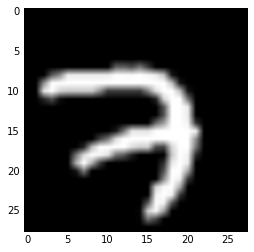

In [3]:
plt.imshow(mnist.train.images[0].reshape([28, 28]))
plt.gray()

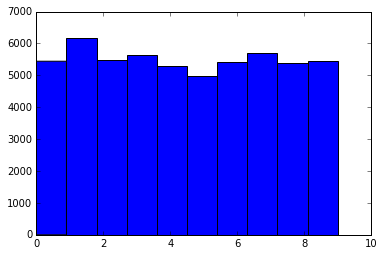

In [4]:
plt.hist(map(lambda v: np.argmax(v), mnist.train.labels))
plt.show()


![output_9_0.png](https://qiita-image-store.s3.amazonaws.com/0/10905/428a0efd-6c38-a948-0842-bfca39bfd1d8.png)


:bulb: 描画する手書き画像のインデックスを変えて、別の手書き画像が表示されるのを確かめてみましょう。

### ラベル（ys）の解説

MNISTのテストデータのラベルは、与えられた画像がどの数字かを表す、0〜9の数字です。今回は、ラベルを[one-hot](https://ja.wikipedia.org/wiki/One-hot)ベクトルの形式で表現します。例えば、「3」を表すラベルは[0,0,0,1,0,0,0,0,0,0]となります。

mnist.train.labelsは、55,000個の10次元ベクトルを格納した[55000, 10]の形の配列になります。

![図](https://www.tensorflow.org/versions/master/images/mnist-train-ys.png)

実際にラベルをひとつ見てみます。




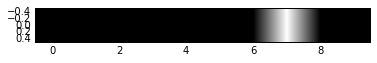

In [5]:
plt.imshow(mnist.train.labels[0].reshape([1, -1]))
plt.gray()


![output_13_0.png](https://qiita-image-store.s3.amazonaws.com/0/10905/5fdbb24c-f52a-e259-c1dc-e9cc1f461e5f.png)


:bulb: 描画するラベルのインデックスを変えて、別のラベルが表示されるのを確かめてみましょう。

## 3. モデルを定義しよう

今回は、[Softmax関数](http://ibisforest.org/index.php?%E3%82%BD%E3%83%95%E3%83%88%E3%83%9E%E3%83%83%E3%82%AF%E3%82%B9%E9%96%A2%E6%95%B0)を用いた回帰モデルを利用します。

### Softmax回帰の解説

今回のモデルの目標は、手書き画像を見たときに、それがどの数字であるか確率を得られるようにすることです。例えば、モデルが「9」の手書き画像を見たときに、それが80%の確率で「9」である、同時に5%の確率で「8」である（上部にループがあるため）、というイメージです。

これは、Softmax回帰が適しているユースケースのひとつです。例えば、いくつかの結果の選択肢（今回は10通り）が確率分布として与えられたときに、それらの中から1つの結果を選び出したい場合は、Softmax関数を利用することができます。より複雑なモデルを訓練する場合でも、最後にSoftmax関数を利用することができます。

Softmax回帰は、次の2つのステップからなります。

1. 入力された手書き画像が、ある特定のラベルに該当するエビデンスを足し合わせる
2. エビデンスを確率に変換する

今回は、与えられた画像が特定のラベルに該当するエビデンスを合計するために、ピクセル強度の重み付き和を計算します。

次の図は、あるモデルが、これらのクラスのそれぞれについて学習した重みを示しています。
赤い部分が文字の特徴を強めるピクセル、青い部分が文字の特徴を弱めるピクセルです。

![図](https://www.tensorflow.org/versions/master/images/softmax-weights.png)

また、バイアスと呼ばれるエビデンスを追加します。これは、入力によらず該当確率が高いというケースを表現するためです。

#### Softmap回帰の式

与えられた入力 $x$ がラベル $i$ に該当するというエビデンスは、次式で表されます。



$$ \text{evidence}_i = \sum_j W_{i,~ j} x_j + b_i \tag{3.1} $$



* $W_i$ : 重み
* $b_i$ : ラベル $i$ のバイアス
* $j$ : 入力画像 $x$ 内のピクセルを加算するためのインデックス

Softmax関数を使ってエビデンスの合計を予測確率 $y$ に変換します。



$$ y = \text{softmax}(\text{evidence}) \tag{3.2} $$



ここでSoftmax関数は、線形関数の出力フォーマットを整形するための[活性化関数](https://ja.wikipedia.org/wiki/%E6%B4%BB%E6%80%A7%E5%8C%96%E9%96%A2%E6%95%B0)として利用されています。

Softmax関数の定義は次式で表されます。



$$ \text{softmax}(x) = \text{normalize}(\exp(x)) \tag{3.3} $$



式を展開すると、次のようになります。



$$ \text{softmax}(x)_i = \frac{\exp(x_i)}{\sum_j \exp(x_j)} \tag{3.4} $$



直感的には(3.3)式の形で考えるのが一番理解しやすいかもしれません。

Softmax回帰は、次図で表すことができます（実際の $x$ は更に多いです）。入力 $x$ に対して重み付き和を計算し、バイアスを加え、Softmax関数を適用します。

![図](https://www.tensorflow.org/versions/master/images/softmax-regression-scalargraph.png)

方程式で書くと次図のようになります。

![図](https://www.tensorflow.org/versions/master/images/softmax-regression-scalarequation.png)

この手続きを行列の乗算とベクトルの加算に変えることで、[ベクトル化](https://ja.wikipedia.org/wiki/%E3%83%99%E3%82%AF%E3%83%88%E3%83%AB%E5%8C%96)することができます。

![図](https://www.tensorflow.org/versions/master/images/softmax-regression-vectorequation.png)

簡単に書くと次のようになります。

$$ y = \text{softmax}(Wx + b) \tag{3.5} $$

### Softmax回帰の実装

まずは入力 $x$ をシンボリックな変数として定義します。




In [6]:
x = tf.placeholder("float",[None,784])


xは特定の値ではなく、placeholderと呼ばれます。TensorFlowに計算を依頼するときに入力する値です。手書き画像は784次元ベクトルですから、これを[None, 784]の2次元テンソルとして表現します。

また、weightやbiasesの定義にはVariableを利用します。Variableは変更可能なテンソルです。




In [7]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))


変数が揃いました。次のようにモデルを定義します。




In [8]:
y = tf.nn.softmax(tf.matmul(x,W)+b)


:bulb: 余裕があれば多層パーセプトロンのモデルを作ってみましょう。

## 4. モデルの訓練方法を定義しよう

モデルの当てはまりの良さを定量的に評価するため、誤差関数（別名：コスト関数、損失関数）を定義します。今回は、[交差エントロピー](https://ja.wikipedia.org/wiki/%E4%BA%A4%E5%B7%AE%E3%82%A8%E3%83%B3%E3%83%88%E3%83%AD%E3%83%94%E3%83%BC)と呼ばれる誤差関数を用います。

### 訓練方法の解説

交差エントロピーは、2つの確率分布の間に定義されるエントロピーです。
今回は、「予測されたラベル」「正解ラベル」の2つの確率分布がありますから、交差エントロピーが利用できるのです。

交差エントロピーは次式で定義されます。



$$ H_{y'}(y) = -\sum_i y'_i \log(y_i) $$



ここで、 $y$ は今回予測した結果の確率分布で、 $y'$ が真の分布です。

### 訓練方法の実装

交差エントロピーの計算を実行するために、まずは正解データを入力するためのplaceholderを定義します。




In [9]:
y_ = tf.placeholder("float",[None,10])


次のように交差エントロピーを定義します。




In [10]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


訓練方法を定義します。




In [21]:
learning_rate = 0.01
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)


:bulb: [Optimizer](http://www.tensorflow.org/api_docs/python/train.html#optimizers)やlearning_rateを差し替えて、動作を見てみましょう。後の分類精度にも影響することが分かるはずです。

## 5. モデルを実際に訓練しよう

訓練方法を定義したら、いよいよ実際に訓練を行います。

訓練を開始する前に、ここまでに定義した変数を初期化するための命令を作成します(まだ実行はされません)。




In [22]:
init = tf.initialize_all_variables()


TensorFlowのセッションを開始し、変数を初期化するための命令を実行します。今回は、TensorFlowのコードをJupyter上でインタラクティブに実行するため、`tf.InteractiveSession()`を使用しています。




In [23]:
sess = tf.InteractiveSession()
sess.run(init)

Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x1190099d0>> ignored



訓練を実行します。今回は訓練を1,000回繰り返しています。

**:bangbang: 注意：訓練パラメータを変更して再度訓練を行う場合は、毎回 tf.initialize_all_variables() を呼んで、学習済みの変数を初期化してから実行してください :bangbang:**




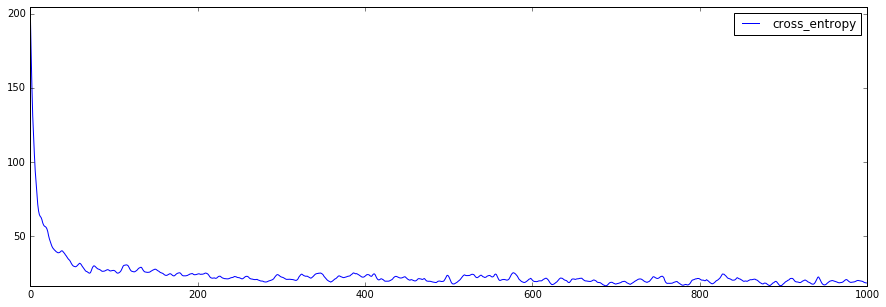

In [24]:
# 訓練パラメータ
n_train = 1000
n_batch = 100

# グラフ描画用
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
xvalues = np.arange(n_train)
yvalues = np.zeros(n_train)
lines, = ax.plot(xvalues, yvalues, label="cross_entropy")

for i in range(n_train):

    # バッチ学習
    batch_xs, batch_ys = mnist.train.next_batch(n_batch)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    
    # グラフ描画用
    yvalues[i] = cross_entropy.eval(feed_dict={x: mnist.test.images[0:100], y_: mnist.test.labels[0:100]})
    lines.set_data(xvalues, yvalues)
    ax.set_ylim((yvalues.min(), yvalues.max()))
    plt.legend()
    plt.pause(.00001)


![output_50_0.png](https://qiita-image-store.s3.amazonaws.com/0/10905/bb2b2a24-bd99-c256-97b1-2bf9a9278b52.png)


:bulb: 訓練パラメータ`n_train`や`n_batch`の値を変えて、動作を見てみましょう。後の分類精度にも影響することが分かるはずです。

ループの各ステップで、訓練データから100個のランダムデータ（バッチ）を取得しています。こうしたランダムデータの小さなバッチを使う手法を確率的訓練と呼び、今回は[確率的勾配降下法](https://ja.wikipedia.org/wiki/%E7%A2%BA%E7%8E%87%E7%9A%84%E5%8B%BE%E9%85%8D%E9%99%8D%E4%B8%8B%E6%B3%95)になります。

## 6. 作成したモデルを評価しよう

TensorFlowの関数を利用し、実際の評価結果を次のように導出します。

* `tf.argmax(y,1)` : 最も確からしいラベル
* `tf.argmax(y_,1)` : 正解ラベル

これらを元に、正解率を計算します。




In [25]:
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))


correct_predictionはbool値のテンソルです。正解率を計算するため、float値にキャストして平均値を取ります。




In [26]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9239



    0.9123


正解率は91%程度になるはずです。

ちなみに「正解率（accuracy）」というのは厳密に定義された精度指標です。類似の精度指標と混同しないように気をつけましょう。

* [そろそろ本気で機械学習の評価方法について学習するよ - Web就活日記](http://yut.hatenablog.com/entry/20120910/1347233734)

さて、学習された$W$の中身を可視化してみます。左上から順に0~9まで並んでいます。赤い部分が文字の特徴を強めるピクセル、青い部分が文字の特徴を弱めるピクセルです。




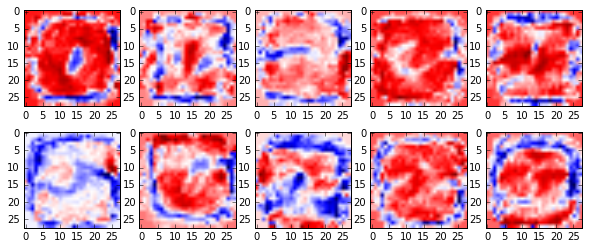

In [27]:
w = W.eval().T
fig = plt.figure(figsize=(10, 4))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(w[i].reshape([28, 28]), cmap="seismic")


![output_59_0.png](https://qiita-image-store.s3.amazonaws.com/0/10905/4a078074-0ef7-07c4-a862-bec20d8acae4.png)

:bulb: [colormap](http://matplotlib.org/examples/color/colormaps_reference.html)を変えると色を変えることができます。

## 7. 作成したモデルを使って分類してみよう

モデルに手書き画像を与えて、分類結果を見てみます。




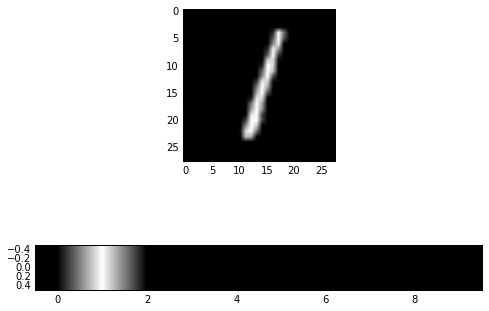

In [28]:
# 手書き画像のインデックス
index_test_image = 2

# 分類
result = y.eval(feed_dict={x: [mnist.test.images[index_test_image]]})

# 描画の準備
fig = plt.figure(figsize=(8, 6))

# テスト画像を描画
ax0 = fig.add_subplot(2, 1, 1)
ax0.imshow(mnist.test.images[index_test_image].reshape([28, 28]))

# 分類結果を描画
ax1 = fig.add_subplot(2, 1, 2)
ax1.imshow(result)

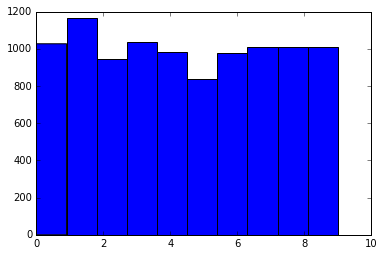

In [29]:
indeces = []

for i in range(len(mnist.test.images)):
    result = y.eval(feed_dict={ x: [mnist.test.images[i]] })
    indeces.append(np.argmax(result))

plt.hist(indeces)
plt.show()


![output_63_1.png](https://qiita-image-store.s3.amazonaws.com/0/10905/9ee3c357-c790-1ef9-6373-18a87b063438.png)


該当する数字の部分が白くなっているはずです。うまく分類できているでしょうか？

:bulb: 与える手書き画像のインデックスを変えて、分類結果を見てみましょう。

## まとめ

Notebook上で色々とコードをいじって理解を深めてみてください。

## 参考文献

* [MNIST For ML Beginners](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/beginners/index.html#mnist-for-ml-beginners)
* [TensorFlowチュートリアル - ML初心者のためのMNIST（翻訳） - Qiita](http://qiita.com/KojiOhki/items/ff6ae04d6cf02f1b6edf)
* [TensorFlowでDeep Neural Networks (3) 多層パーセプトロン - Qiita](http://qiita.com/kumonkumon/items/15dbdb291f3525a3b95b)
* [落ちこぼれないためのTensorFlow Tutorialコード - Qiita](http://qiita.com/TomokIshii/items/92a266b805d7eee02b1d)
* [Visual Information Theory -- colah's blog](https://colah.github.io/posts/2015-09-Visual-Information/)
* [Neural networks and deep learning](http://neuralnetworksanddeeplearning.com/chap3.html#softmax)

